In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

inflows = pd.read_parquet("../data/ucsd-inflows.pqt")
outflows = pd.read_parquet("../data/ucsd-outflows.pqt")
import re

def clean_text(data):
    df = data.copy()

    # create the patterns

    # pattern1 handles the dates, and the states 
    pattern1 = r'\b(?:CA\s+)?(?:0?[1-9]|1[0-2])[/-](?:0?[1-9]|[12]\d|3[01])(?:/\d{2,4})?\b'

    # pattern2 handles unnecessary X's
    pattern2 = r'(?<!#)XX+|#XX+'

    # Handles unnecessary punctuation
    pattern3 = r"[^a-zA-Z0-9\s./]"

    # get rid of the state at the end of the wording
    pattern4 = r'\s[A-Z]{2}$'

    # Handles "POS WITHDRAWAL | DEBIT CARD WITHDRAWL"
    pattern5 = r'(pos withdrawal|debit card withdrawal)'

    # handles the word "purchase"
    pattern6 = r'(purchase)'

    # make everything lower case, and get rid of unnecessary spacing between words
    df['memo'] = df['memo'].apply(lambda x: re.sub(pattern3, '', re.sub(pattern2, '', re.sub(pattern1, '', x))))
    df['memo'] = df['memo'].apply(lambda x: " ".join(x.split()).strip())
    df['memo'] = df['memo'].apply(lambda x: re.sub(pattern4, '', x))
    df["memo"] = df["memo"].apply(lambda x: re.sub(pattern6, '', re.sub(pattern5, '', x.lower())))
    return df
not_matching = outflows[outflows['memo'] != outflows['category']]
cleaned_not_matching = clean_text(not_matching)
#cleaned_inflows = clean_text(inflows)
#cleaned_outflows = clean_text(outflows)

In [2]:
cleaned_not_matching

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
2,0,acc_0,tst casa del rio exp fairlawn,18.42,2022-09-26,FOOD_AND_BEVERAGES
4,0,acc_0,buffalo wild wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
6,0,acc_0,oculus,11.73,2022-04-18,GENERAL_MERCHANDISE
7,0,acc_0,los girasoles stow,30.04,2022-03-09,FOOD_AND_BEVERAGES
8,0,acc_0,buzzis laundry 1,4.16,2022-03-29,GENERAL_MERCHANDISE
...,...,...,...,...,...,...
2597457,5941,acc_9524,amazon primeti40l27r3 amzn.com/bill wa date p...,15.93,2023-01-16,GENERAL_MERCHANDISE
2597462,5941,acc_9524,az lot quiktrip e indian school rd phoenix az ...,25.00,2023-01-18,EDUCATION
2597465,5941,acc_9524,walmart e mckellips rd mesa az card 15 mcc,3.68,2023-01-18,FOOD_AND_BEVERAGES
2597468,5941,acc_9524,withdrawal salt river projetype online pmt cos...,90.00,2023-01-20,FOOD_AND_BEVERAGES


In [3]:
#w_cleaned_inflows = cleaned_inflows.copy()  
w_cleaned_outflows = cleaned_not_matching.copy()
#w_cleaned_outflows = cleaned_outflows.copy()

def add_text(memo, added_tokens):
    memo += ''.join(added_tokens)
    return memo

def whole_dollar_amount(amount):
    if amount % 1 == 0:
        return ' <W_D>'
    return ''

def day(date):
    return f" <D_{date.day}>"

def month(date):
    return f" <M_{date.month}>"


w_cleaned_outflows['memo'] = w_cleaned_outflows.apply(
    lambda row: add_text(row['memo'], 
                         [whole_dollar_amount(row['amount']), 
                          day(row['posted_date']),
                         month(row['posted_date'])]), axis=1
)

# Logistic Regression with tf-idf

In [4]:
# Splitting the data into train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(
    w_cleaned_outflows['memo'], 
    w_cleaned_outflows['category'], 
    test_size=0.2, 
    random_state=42
)
print('Data split complete')

# Vectorizing the text data - fit only on training data, transform on test data
vectorizer = TfidfVectorizer(max_features=5000, max_df=0.95, min_df=5)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)
print('Vectorization complete')

# Encoding the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
print('Label encoding complete')

# Fitting the Logistic Regression model
log_reg = LogisticRegression(solver='saga', max_iter=200, n_jobs=-1)
log_reg.fit(X_train, y_train)
print('Logistic Regression model trained')
print('-----------------------------------------------------------------')
print()

# Making predictions and calculating accuracy
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print()

# Getting predicted probabilities
y_prob = log_reg.predict_proba(X_test)

# Calculating ROC-AUC score for each category individually
roc_auc_scores = {}
for i, category in enumerate(label_encoder.classes_):
    y_test_binary = np.where(y_test == i, 1, 0)  # Binary label for the current category
    
    # Only calculate ROC-AUC if there are both positive and negative samples
    if len(np.unique(y_test_binary)) == 2:
        roc_auc_scores[category] = roc_auc_score(y_test_binary, y_prob[:, i])
    else:
        roc_auc_scores[category] = "Undefined (only one class in y_test)"

# Displaying the ROC-AUC score for each category
print("ROC-AUC Scores per Category:")
for category, score in roc_auc_scores.items():
    print(f"{category}: {score}")


Data split complete
Vectorization complete
Label encoding complete
Logistic Regression model trained
-----------------------------------------------------------------

Accuracy: 0.9614912109487124

ROC-AUC Scores per Category:
EDUCATION: 0.9937498683677517
FOOD_AND_BEVERAGES: 0.9956159990179156
GENERAL_MERCHANDISE: 0.9955593730028379
GROCERIES: 0.998139271303887
MORTGAGE: 1.0
OVERDRAFT: 0.9999370577883504
PETS: 0.9986481394220531
RENT: 0.9968906071672331
TRAVEL: 0.998274883024098


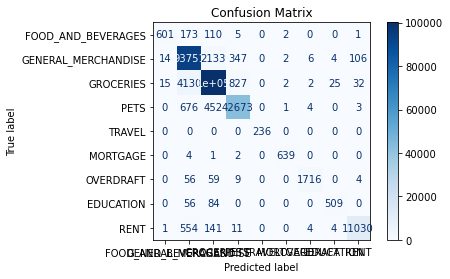

In [6]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=w_cleaned_outflows['category'].unique())  # Adjust labels to match your categories
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Random Forrest

In [9]:
# Splitting the data into train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(
    w_cleaned_outflows['memo'], 
    w_cleaned_outflows['category'], 
    test_size=0.2, 
    random_state=42
)
print('Data split complete')

# Vectorizing the text data - fit only on training data, transform on test data
vectorizer = TfidfVectorizer(max_features=2000, max_df=0.95, min_df=5)
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)
print('Vectorization complete')

# Fitting the Logistic Regression model
ran_for = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=60)
ran_for.fit(X_train, y_train)
print('Random Forrest model trained')
print('-----------------------------------------------------------------')
print()

# Making predictions and calculating accuracy
y_pred = ran_for.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print('-----------------------------------------------------------------')
print()

# Getting predicted probabilities
y_prob = ran_for.predict_proba(X_test)

y_test_binarized = label_binarize(y_test, classes=w_cleaned_outflows['category'].unique())  # Replace classes with your actual class labels

# Calculate ROC AUC for each category
roc_auc_per_class = roc_auc_score(y_test_binarized, y_prob, average=None)
for idx, auc in enumerate(roc_auc_per_class):
    print(f"ROC AUC for category {idx}: {auc:.4f}")
print('-----------------------------------------------------------------')
print()

# Calculate accuracy for each category (one-vs-all approach)
for category in set(y_test):
    # Convert to binary labels for one-vs-all accuracy
    y_test_binary = (y_test == category).astype(int)
    y_pred_binary = (y_pred == category).astype(int)
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    print(f"Accuracy for category {category}: {accuracy:.4f}")

Data split complete
Vectorization complete
Random Forrest model trained
-----------------------------------------------------------------

Accuracy: 0.8427806545192907
-----------------------------------------------------------------

ROC AUC for category 0: 0.6648
ROC AUC for category 1: 0.1965
ROC AUC for category 2: 0.1667
ROC AUC for category 3: 0.4826
ROC AUC for category 4: 0.4506
ROC AUC for category 5: 0.7607
ROC AUC for category 6: 0.3297
ROC AUC for category 7: 0.8250
ROC AUC for category 8: 0.7506
-----------------------------------------------------------------

Accuracy for category GENERAL_MERCHANDISE: 0.8991
Accuracy for category OVERDRAFT: 0.9998
Accuracy for category EDUCATION: 0.9967
Accuracy for category TRAVEL: 0.9838
Accuracy for category RENT: 0.9984
Accuracy for category MORTGAGE: 0.9993
Accuracy for category PETS: 0.9960
Accuracy for category FOOD_AND_BEVERAGES: 0.8476
Accuracy for category GROCERIES: 0.9649


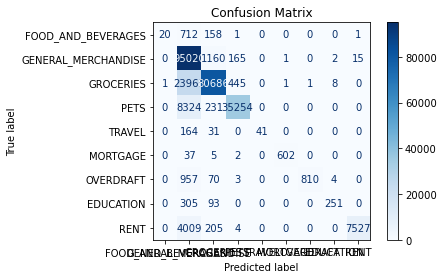

In [10]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=w_cleaned_outflows['category'].unique())  # Adjust labels to match your categories
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()